In [ ]:
!pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00


In [ ]:
!pip install onnx onnx-tf
!pip install tensorflow-addons==0.19.0 --force-reinstall
!pip install onnx_tf==1.10.0
!pip install onnxruntime
!pip install folium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ERROR: Could not find a version that satisfies the requirement tensorflow-addons==0.19.0 (from versions: 0.20.0, 0.21.0, 0.22.0, 0.23.0)
ERROR: No matching distribution found for tensorflow-addons==0.19.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/MARIDA.zip'

# Directory to extract files to
extract_to = '/content/MARIDA'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")


Files extracted to: /content/MARIDA


In [ ]:
# -*- coding: utf-8 -*-
'''
Author: Ioannis Kakogeorgiou (Modified)
Email: gkakogeorgiou@gmail.com
Python Version: 3.7.10+
Description: Updated dataloader.py for multi-label classification using the MARIDA dataset.
'''

import os
import json
import torch
import random
import numpy as np
from tqdm import tqdm
from osgeo import gdal
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Pixel-level number of negative/number of positive per class
pos_weight = torch.Tensor([
    2.65263158, 27.91666667, 11.39285714, 18.82857143,  6.79775281,
    6.46236559,  0.60648148, 27.91666667, 22.13333333,  5.03478261,
    17.26315789, 29.17391304, 16.79487179, 12.88,        9.05797101
])

bands_mean = np.array([
    0.05197577, 0.04783991, 0.04056812, 0.03163572, 0.02972606,
    0.03457443, 0.03875053, 0.03436435, 0.0392113,  0.02358126,
    0.01588816
]).astype('float32')

bands_std = np.array([
    0.04725893, 0.04743808, 0.04699043, 0.04967381, 0.04946782,
    0.06458357, 0.07594915, 0.07120246, 0.08251058, 0.05111466,
    0.03524419
]).astype('float32')

###############################################################
# Multi-label classification Data Loader                      #
###############################################################
dataset_path = '/content/MARIDA'  # ✅ Updated to your dataset path

class GenDEBRIS_ML(Dataset):
    def __init__(self, mode='train', transform=None, standardization=None, path=dataset_path, agg_to_water=True):
        split_file = os.path.join(path, 'splits', f'{mode}_X.txt')
        assert os.path.isfile(split_file), f"Split file not found: {split_file}"
        self.ROIs = np.genfromtxt(split_file, dtype='str')

        self.X = []
        self.y = []

        # Load labels
        labels_path = os.path.join(path, 'labels_mapping.txt')
        assert os.path.isfile(labels_path), f"Labels file not found: {labels_path}"
        with open(labels_path, 'r') as f:
            labels = json.load(f)

        # Aggregate mixed water-related classes into marine water
        if agg_to_water:
            for k in labels.keys():
                if labels[k][14] == 1 or labels[k][13] == 1 or labels[k][12] == 1 or labels[k][11] == 1:
                    labels[k][6] = 1  # Merge into marine water
                labels[k] = labels[k][:-4]  # Drop last 4 classes

        # Load image data and labels into memory
        for roi in tqdm(self.ROIs, desc=f'Loading {mode} set'):
            roi_folder = '_'.join(['S2'] + roi.split('_')[:-1])
            roi_name = '_'.join(['S2'] + roi.split('_'))
            roi_file = os.path.join(path, 'patches', roi_folder, roi_name + '.tif')

            if not os.path.exists(roi_file):
                raise FileNotFoundError(f"Image file not found: {roi_file}")

            ds = gdal.Open(roi_file)
            img_array = np.copy(ds.ReadAsArray())
            ds = None

            self.X.append(img_array)
            self.y.append(labels[roi_name + '.tif'])

        # Prepare for NaN imputation
        self.impute_nan = np.tile(bands_mean, (img_array.shape[1], img_array.shape[2], 1))
        self.mode = mode
        self.transform = transform
        self.standardization = standardization
        self.length = len(self.y)
        self.path = path

    def __len__(self):
        return self.length

    def getnames(self):
        return self.ROIs

    def __getitem__(self, index):
        img = self.X[index]
        target = torch.tensor(self.y[index]).float()

        # Convert from (C, H, W) to (H, W, C)
        img = np.moveaxis(img, [0, 1, 2], [2, 0, 1]).astype('float32')

        # Impute NaNs with mean
        nan_mask = np.isnan(img)
        img[nan_mask] = self.impute_nan[nan_mask]

        if self.transform is not None:
            img = self.transform(img.astype('float32'))

        if self.standardization is not None:
            img = self.standardization(img)

        return img, target

###############################################################
# Random Rotation Transform                                   #
###############################################################
class RandomRotationTransform:
    """Rotate image by one of the given angles randomly."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return F.rotate(x, angle)

###############################################################
# Weighting Function                                          #
###############################################################
def gen_weights(pos_weight, c=1.4):
    return 1 / torch.log(c + pos_weight)


In [ ]:
# -*- coding: utf-8 -*-
'''
Original Paper: Kaiming He et al., 2016 (https://doi.org/10.1109/CVPR.2016.90)
Author (This implementation): Ioannis Kakogeorgiou
Email: gkakogeorgiou@gmail.com
Python Version: 3.7.10
Description: resnet.py ResNet model for multi-label Classification.
'''

import torch.nn as nn
import torch.nn.init as init
from torchvision import models

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or type(m) == nn.Linear:
        init.kaiming_normal_(m.weight.data)

class ResNet(nn.Module):
    def __init__(self, input_bands = 11, output_classes = 11):
        super().__init__()

        resnet = models.resnet50(pretrained=False)

        # Encoder
        self.encoder = nn.Sequential(
                        nn.Conv2d(input_bands, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
                        resnet.bn1,
                        resnet.relu,
                        resnet.maxpool,
                        resnet.layer1,
                        resnet.layer2,
                        resnet.layer3,
                        resnet.layer4,
                        resnet.avgpool)

        # Classification Layer
        self.fc = nn.Linear(2048, output_classes)

        self.apply(weights_init_kaiming)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        # Classification Layer
        logits = self.fc(x)

        return logits

In [ ]:
from dataloader import GenDEBRIS_ML

train_dataset = GenDEBRIS_ML(mode='train', path='/content/MARIDA')
val_dataset = GenDEBRIS_ML(mode='val', path='/content/MARIDA')
test_dataset = GenDEBRIS_ML(mode='test', path='/content/MARIDA')


Load test set to memory: 100%|██████████| 359/359 [00:06<00:00, 54.75it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from dataloader import GenDEBRIS_ML  # Make sure your dataloader file is in the right place

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform for DEBRIS 11-band input
def tensor_transform(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img)
    if img.shape[0] != 11:
        img = img.permute(2, 0, 1)  # HWC to CHW

    img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    bands_mean = torch.tensor([0.05197577, 0.04783991, 0.04056812, 0.03163572, 0.02972606,
                               0.03457443, 0.03875053, 0.03436435, 0.0392113, 0.02358126, 0.01588816])
    bands_std = torch.tensor([0.04725893, 0.04743808, 0.04699043, 0.04967381, 0.04946782,
                              0.06458357, 0.07594915, 0.07120246, 0.08251058, 0.05111466, 0.03524419])

    img = (img - bands_mean[:, None, None]) / bands_std[:, None, None]
    return img

# Datasets and loaders
train_dataset = GenDEBRIS_ML(mode='train', transform=tensor_transform, path='/content/MARIDA')
val_dataset = GenDEBRIS_ML(mode='val', transform=tensor_transform, path='/content/MARIDA')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Modified ResNet18
class ResNet18_Multilabel(nn.Module):
    def __init__(self, num_channels=11, num_classes=11):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet18_Multilabel().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation F1 Score: {f1:.4f}")

# Save model
torch.save(model.state_dict(), '/content/debris_resnet18.pth')
print("Model saved to /content/debris_resnet18.pth")


Loading val set: 100%|██████████| 328/328 [00:03<00:00, 104.73it/s]


Epoch [1/10], Loss: 0.3635
Epoch [1/10], Validation F1 Score: 0.3814
Epoch [2/10], Loss: 0.2798
Epoch [2/10], Validation F1 Score: 0.4637
Epoch [3/10], Loss: 0.2689
Epoch [3/10], Validation F1 Score: 0.5024
Epoch [4/10], Loss: 0.2567
Epoch [4/10], Validation F1 Score: 0.4674
Epoch [5/10], Loss: 0.2604
Epoch [5/10], Validation F1 Score: 0.4668
Epoch [6/10], Loss: 0.2482
Epoch [6/10], Validation F1 Score: 0.5428
Epoch [7/10], Loss: 0.2369
Epoch [7/10], Validation F1 Score: 0.5372
Epoch [8/10], Loss: 0.2360
Epoch [8/10], Validation F1 Score: 0.5387
Epoch [9/10], Loss: 0.2266
Epoch [9/10], Validation F1 Score: 0.5784
Epoch [10/10], Loss: 0.2177
Epoch [10/10], Validation F1 Score: 0.5772
Model saved to /content/debris_resnet18.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import f1_score
import torch.nn.functional as F
from dataloader import GenDEBRIS_ML  # Your custom dataloader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom transform function for 11-band images
def tensor_transform(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img)
    if img.shape[0] != 11:
        img = img.permute(2, 0, 1)  # HWC to CHW

    img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    bands_mean = torch.tensor([0.05197577, 0.04783991, 0.04056812, 0.03163572, 0.02972606,
                               0.03457443, 0.03875053, 0.03436435, 0.0392113, 0.02358126, 0.01588816])
    bands_std = torch.tensor([0.04725893, 0.04743808, 0.04699043, 0.04967381, 0.04946782,
                              0.06458357, 0.07594915, 0.07120246, 0.08251058, 0.05111466, 0.03524419])

    img = (img - bands_mean[:, None, None]) / bands_std[:, None, None]
    return img

# Data preparation
train_dataset = GenDEBRIS_ML(mode='train', transform=tensor_transform, path='/content/MARIDA')
val_dataset = GenDEBRIS_ML(mode='val', transform=tensor_transform, path='/content/MARIDA')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# CNN + ResNet18 hybrid model
class CNNResNet18(nn.Module):
    def __init__(self, num_channels=11, num_classes=11):
        super().__init__()
        # Load pretrained ResNet18 and modify
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove ResNet18's classifier
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])  # up to layer4

        # CNN Head
        self.cnn_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cnn_head(x)
        return x

model = CNNResNet18().to(device)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation F1 Score: {f1:.4f}")

# Save model
torch.save(model.state_dict(), '/content/cnn_resnet18_debris.pth')
print("Hybrid model saved at /content/cnn_resnet18_debris.pth")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda


100%|██████████| 1.58G/1.58G [00:18<00:00, 93.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/surajit651/souvikdataset/versions/1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.3MB/s]


Epoch [1/10], Loss: 12.2457, Accuracy: 81.69%
Epoch [2/10], Loss: 7.5486, Accuracy: 88.55%
Epoch [3/10], Loss: 5.5786, Accuracy: 92.33%
Epoch [4/10], Loss: 4.0712, Accuracy: 93.95%
Epoch [5/10], Loss: 3.5384, Accuracy: 95.29%
Epoch [6/10], Loss: 3.5566, Accuracy: 95.29%
Epoch [7/10], Loss: 3.0857, Accuracy: 95.87%
Epoch [8/10], Loss: 2.8903, Accuracy: 96.16%
Epoch [9/10], Loss: 2.9101, Accuracy: 95.93%
Epoch [10/10], Loss: 2.8118, Accuracy: 96.28%
🎉 Final Test Accuracy: 77.67%


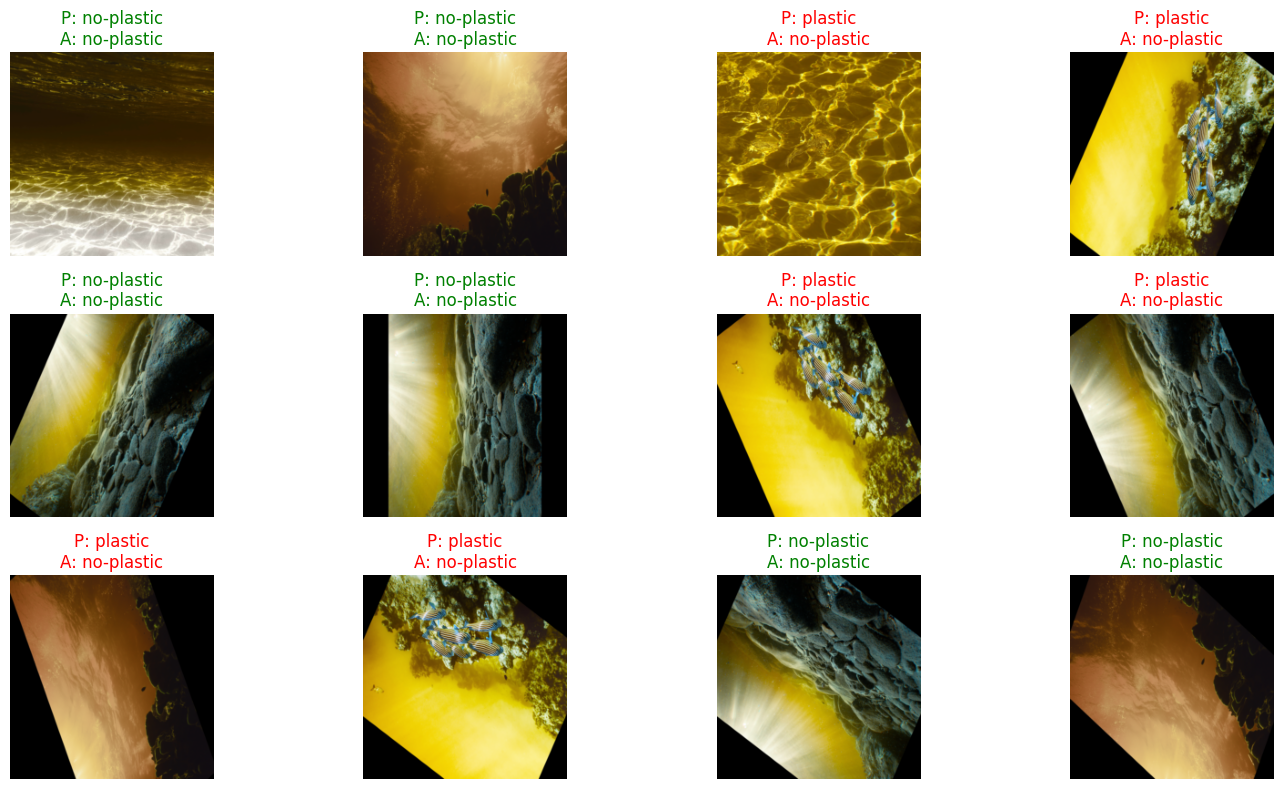

In [ ]:
# ✅ Hybrid Model: CNN + ResNet18
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# ✅ Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Download dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
print("Path to dataset files:", path)

# ✅ Paths
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Image Transformations with Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# ✅ Hybrid Model: CNN + ResNet18
class HybridCNNResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridCNNResNet, self).__init__()

        # Custom CNN Feature Extractor
        self.cnn_features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
        )

        # Pretrained ResNet18 (adjusted first conv layer)
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # Freeze earlier layers if required
        for name, param in self.resnet.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.cnn_features(x)
        x = self.resnet(x)
        return x

# ✅ Initialize Model
model = HybridCNNResNet(num_classes=2).to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# ✅ Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# ✅ Evaluation with Visualization
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())
        all_images.extend(images.cpu())

# ✅ Accuracy
accuracy = 100 * correct / total
print(f"🎉 Final Test Accuracy: {accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    return img

# ✅ Visualization: Show 12 Random Images with Predictions
def show_predictions(images, labels, preds, class_names):
    plt.figure(figsize=(15, 8))
    for idx in range(12):
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Class Names (from dataset)
class_names = train_dataset.classes  # e.g., ['no-plastic', 'plastic']

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds, class_names)


Device: cuda


<ipython-input-25-818470683610>:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-25-818470683610>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10], Loss: 116.3589, Accuracy: 75.87%
Epoch [2/10], Loss: 91.6732, Accuracy: 81.28%
Epoch [3/10], Loss: 93.7980, Accuracy: 81.22%
Epoch [4/10], Loss: 107.9359, Accuracy: 75.70%
Epoch [5/10], Loss: 136.2411, Accuracy: 59.24%
Epoch [6/10], Loss: 149.5612, Accuracy: 48.90%
Epoch [7/10], Loss: 149.3983, Accuracy: 49.19%
Epoch [8/10], Loss: 149.4007, Accuracy: 50.35%
Epoch [9/10], Loss: 149.3012, Accuracy: 50.23%
Epoch [10/10], Loss: 149.2583, Accuracy: 50.64%
✅ Final Test Accuracy: 51.16%


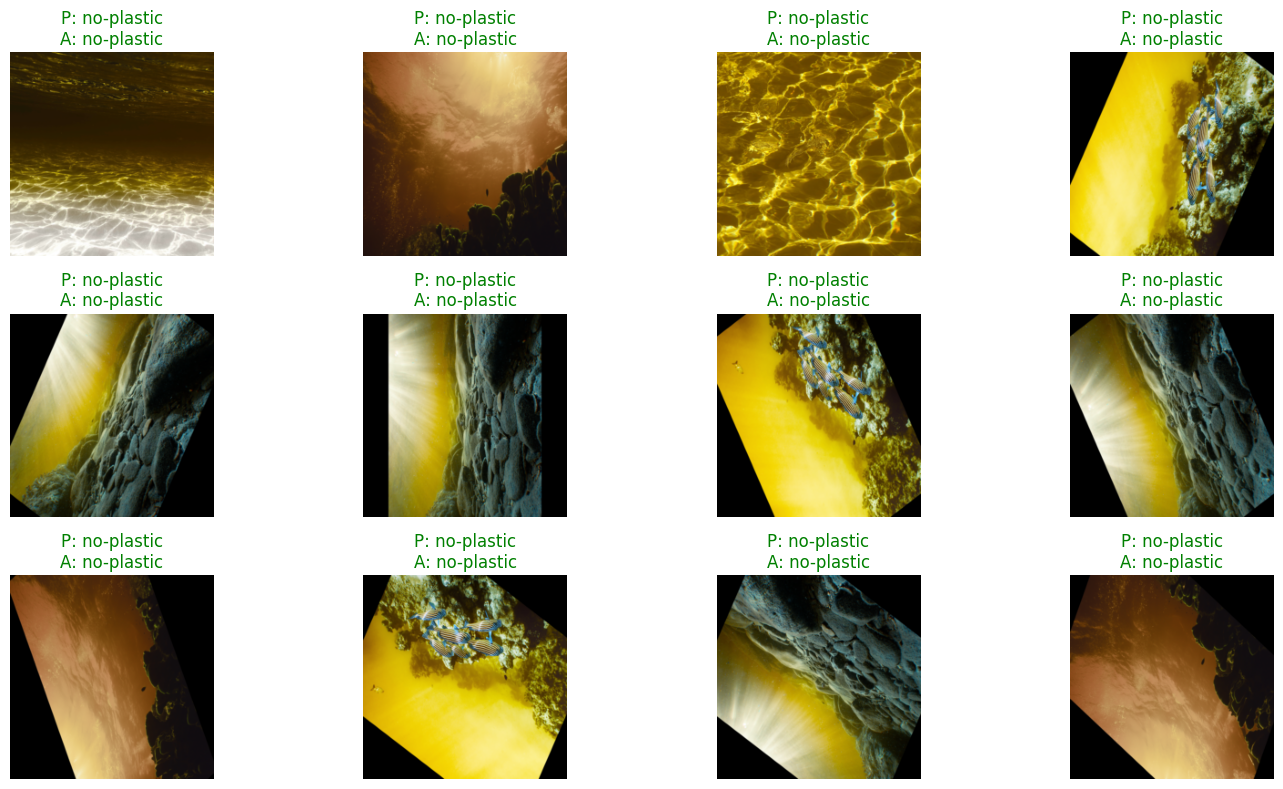

In [ ]:
# ✅ Hybrid CNN + Transformer Model (Swin Transformer)
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gc

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ✅ Clear GPU Memory Before Training
torch.cuda.empty_cache()
gc.collect()

# ✅ Download Dataset (Update with your Kaggle dataset)
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Dataset & DataLoader (Reduced Batch Size to Avoid Memory Errors)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes  # Example: ['no-plastic', 'plastic']

# ✅ Create Optimized Swin Transformer Model (Swin-Tiny to Save Memory)
model = create_model(
    'swin_tiny_patch4_window7_224',  # Swin-Tiny is much smaller than Swin-Base
    pretrained=True,
    num_classes=2
)
model.to(device, non_blocking=True)

# ✅ Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ✅ Mixed Precision Training (Reduces Memory Usage)
scaler = torch.cuda.amp.GradScaler()

# ✅ Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        # ✅ Use Mixed Precision (AMP) to Reduce Memory Usage
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ✅ Free Memory at the End of Each Epoch
    del images, labels, outputs, loss
    torch.cuda.empty_cache()
    gc.collect()

# ✅ Evaluation
model.eval()
total, correct = 0, 0
all_preds, all_labels, all_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_images.extend(images.cpu())

final_accuracy = 100 * correct / total
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

# ✅ Show Predictions
def show_predictions(images, labels, preds):
    plt.figure(figsize=(15, 8))
    for idx in range(min(12, len(images))):  # Avoid Index Errors
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds)


Device: cuda
Epoch [1/10], Loss: 28.4941, Accuracy: 77.50%
Epoch [2/10], Loss: 14.0867, Accuracy: 89.83%
Epoch [3/10], Loss: 11.1479, Accuracy: 92.21%
Epoch [4/10], Loss: 8.8891, Accuracy: 93.37%
Epoch [5/10], Loss: 7.2398, Accuracy: 95.35%
Epoch [6/10], Loss: 4.5889, Accuracy: 96.98%
Epoch [7/10], Loss: 4.8613, Accuracy: 97.09%
Epoch [8/10], Loss: 4.9729, Accuracy: 96.92%
Epoch [9/10], Loss: 2.7647, Accuracy: 98.14%
Epoch [10/10], Loss: 10.9883, Accuracy: 93.84%
✅ Final Test Accuracy: 76.05%


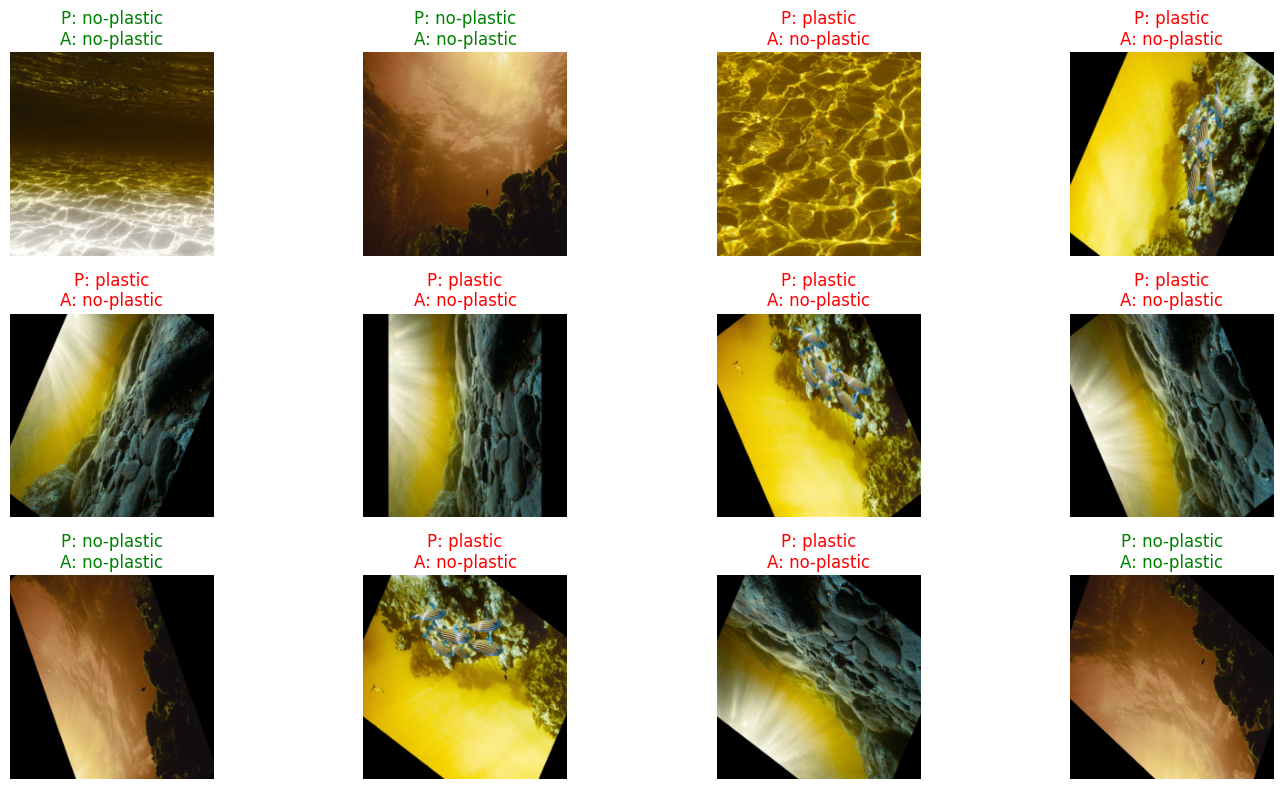

In [ ]:
# ✅ Swin Transformer Model
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ✅ Download Dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Dataset & DataLoader
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = train_dataset.classes  # Labels: ['no-plastic', 'plastic']

# ✅ Swin Transformer Model
model = create_model(
    'swin_base_patch4_window7_224',  # If GPU limited, use 'swin_tiny_patch4_window7_224'
    pretrained=True,
    num_classes=len(class_names)  # Ensure correct class count
)
model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ✅ Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# ✅ Evaluation
model.eval()
total, correct = 0, 0
all_preds, all_labels, all_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # ✅ Store predictions & labels
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_images.extend(images.cpu())

final_accuracy = 100 * correct / total
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

# ✅ Show Predictions
def show_predictions(images, labels, preds):
    plt.figure(figsize=(15, 8))
    for idx in range(min(12, len(images))):  # Ensure we don't exceed available images
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds)


Using device: cuda


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

<ipython-input-24-e768e7358a05>:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-24-e768e7358a05>:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # ✅ Mixed precision for efficiency


Epoch [1/10], Loss: 194.6966, Accuracy: 87.21%
Epoch [2/10], Loss: 57.5170, Accuracy: 94.07%
Epoch [3/10], Loss: 68.7375, Accuracy: 95.47%
Epoch [4/10], Loss: 16.0059, Accuracy: 98.02%
Epoch [5/10], Loss: 16.7360, Accuracy: 97.79%
Epoch [6/10], Loss: 104.2968, Accuracy: 92.56%
Epoch [7/10], Loss: 188.7478, Accuracy: 77.85%
Epoch [8/10], Loss: 77.7693, Accuracy: 85.23%
Epoch [9/10], Loss: 55.2274, Accuracy: 89.36%
Epoch [10/10], Loss: 44.1053, Accuracy: 92.15%


<ipython-input-24-e768e7358a05>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


✅ Final Test Accuracy: 93.49%


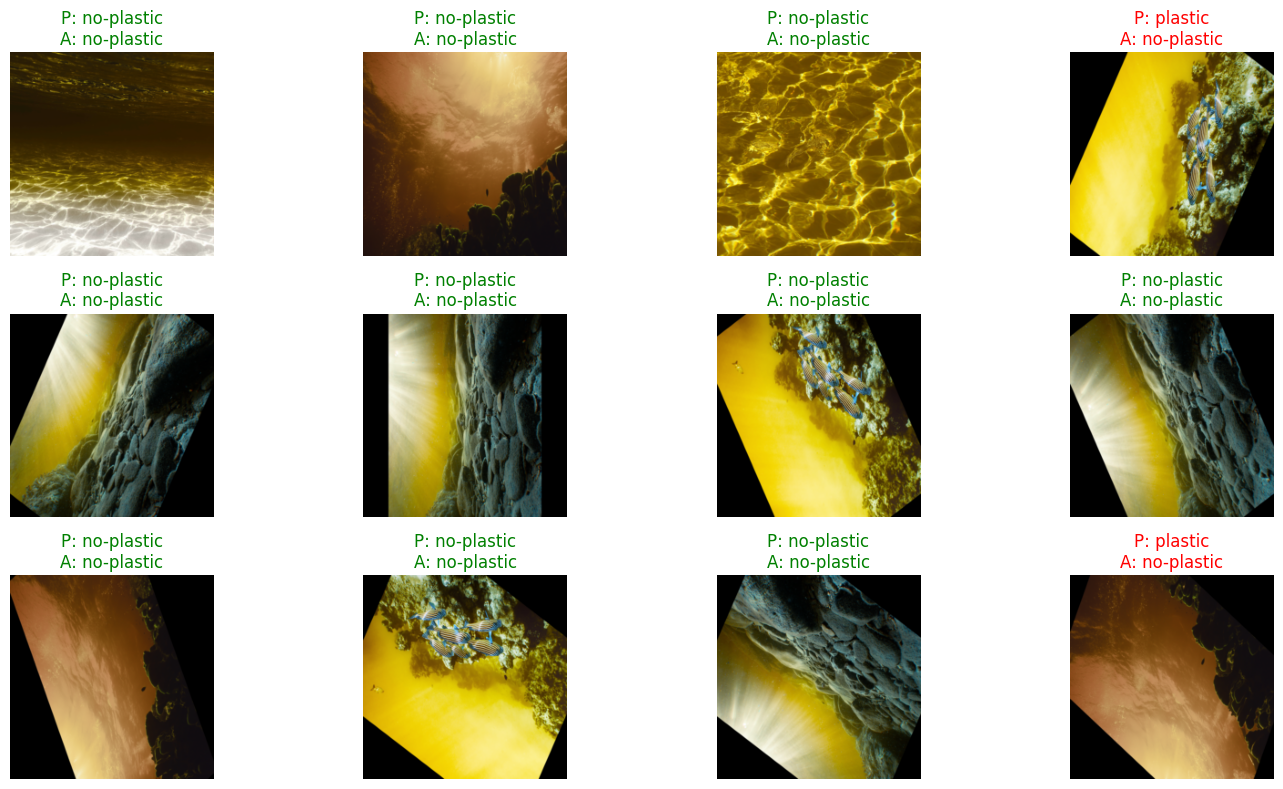

In [ ]:
#EfficientNet-B0
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gc  # Garbage collection for memory

# ✅ Free GPU Memory Before Running
torch.cuda.empty_cache()
gc.collect()

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimized training speed
print(f"Using device: {device}")

# ✅ Download Dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Dataset & DataLoader (Reduced batch size for OOM fix)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes  # Labels: ['no-plastic', 'plastic']

# ✅ Efficient Model (Avoid Swin Transformer due to high memory use)
model = create_model(
    'efficientnet_b0',  # Lower memory model but still high accuracy
    pretrained=True,
    num_classes=len(class_names)
)
model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ✅ Enable Mixed Precision Training
scaler = amp.GradScaler()

# ✅ Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with amp.autocast():  # ✅ Mixed precision for efficiency
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ✅ Free GPU Memory Every Epoch (Critical for avoiding OOM)
    del images, labels, outputs, loss
    torch.cuda.empty_cache()
    gc.collect()

# ✅ Evaluation
model.eval()
total, correct = 0, 0
all_preds, all_labels, all_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with amp.autocast():
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_images.extend(images.cpu())

final_accuracy = 100 * correct / total
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

# ✅ Show Predictions
def show_predictions(images, labels, preds):
    plt.figure(figsize=(15, 8))
    for idx in range(min(12, len(images))):
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds)


In [ ]:
# ✅ Hybrid ResNet + LSTM Model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random

# ✅ Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ✅ Dummy Dataset (Simulating Satellite Images)
class RandomSatelliteDataset(Dataset):
    def __init__(self, num_samples, sequence_length):
        self.num_samples = num_samples
        self.sequence_length = sequence_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Simulate a sequence of images (sequence_length x 3 x 224 x 224)
        sequence = torch.randn(self.sequence_length, 3, 224, 224)
        label = random.randint(0, 1)  # Binary classification
        return sequence, label

# ✅ Hybrid ResNet + LSTM Model
class ResNetLSTM(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(ResNetLSTM, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]  # Remove FC layer
        self.resnet = nn.Sequential(*modules)
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []

        for t in range(seq_len):
            out = self.resnet(x[:, t, :, :, :])  # (batch_size, 512, 1, 1)
            out = out.view(batch_size, -1)  # (batch_size, 512)
            cnn_features.append(out)

        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, seq_len, 512)
        lstm_out, _ = self.lstm(cnn_features)  # (batch_size, seq_len, hidden_dim)
        final_out = lstm_out[:, -1, :]  # Get the last time step
        out = self.fc(final_out)
        return out

# ✅ Hyperparameters
num_classes = 2
hidden_dim = 256
sequence_length = 5
batch_size = 4
num_epochs = 10
learning_rate = 0.001

# ✅ Dataset and DataLoader
train_dataset = RandomSatelliteDataset(num_samples=100, sequence_length=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Model, Loss, Optimizer
model = ResNetLSTM(hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ✅ Training Loop with Accuracy Calculation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print(f"\n✅ Final Training Accuracy after {num_epochs} epochs: {epoch_accuracy:.2f}%")


Using device: cuda
Epoch [1/10], Loss: 17.8426, Accuracy: 55.00%
Epoch [2/10], Loss: 17.6322, Accuracy: 60.00%
Epoch [3/10], Loss: 17.5187, Accuracy: 52.00%
Epoch [4/10], Loss: 17.3581, Accuracy: 46.00%
Epoch [5/10], Loss: 17.4789, Accuracy: 49.00%
Epoch [6/10], Loss: 17.8158, Accuracy: 44.00%
Epoch [7/10], Loss: 17.5915, Accuracy: 49.00%
Epoch [8/10], Loss: 17.3586, Accuracy: 50.00%
Epoch [9/10], Loss: 17.2221, Accuracy: 56.00%
Epoch [10/10], Loss: 17.4843, Accuracy: 45.00%

✅ Final Training Accuracy after 10 epochs: 45.00%


Using device: cuda


100%|██████████| 1.58G/1.58G [00:33<00:00, 50.7MB/s]

Extracting files...



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

<ipython-input-1-02db52003db8>:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-1-02db52003db8>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # ✅ Mixed precision for efficiency


Epoch [1/10], Loss: 181.0236, Accuracy: 86.98%
Epoch [2/10], Loss: 26.5587, Accuracy: 96.10%
Epoch [3/10], Loss: 123.9365, Accuracy: 94.13%
Epoch [4/10], Loss: 40.9170, Accuracy: 95.12%
Epoch [5/10], Loss: 41.4096, Accuracy: 97.15%
Epoch [6/10], Loss: 28.3109, Accuracy: 96.92%
Epoch [7/10], Loss: 12.5828, Accuracy: 98.31%
Epoch [8/10], Loss: 29.6377, Accuracy: 97.50%
Epoch [9/10], Loss: 16.2120, Accuracy: 98.14%
Epoch [10/10], Loss: 2.6423, Accuracy: 99.53%


<ipython-input-1-02db52003db8>:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


✅ Final Test Accuracy: 94.88%


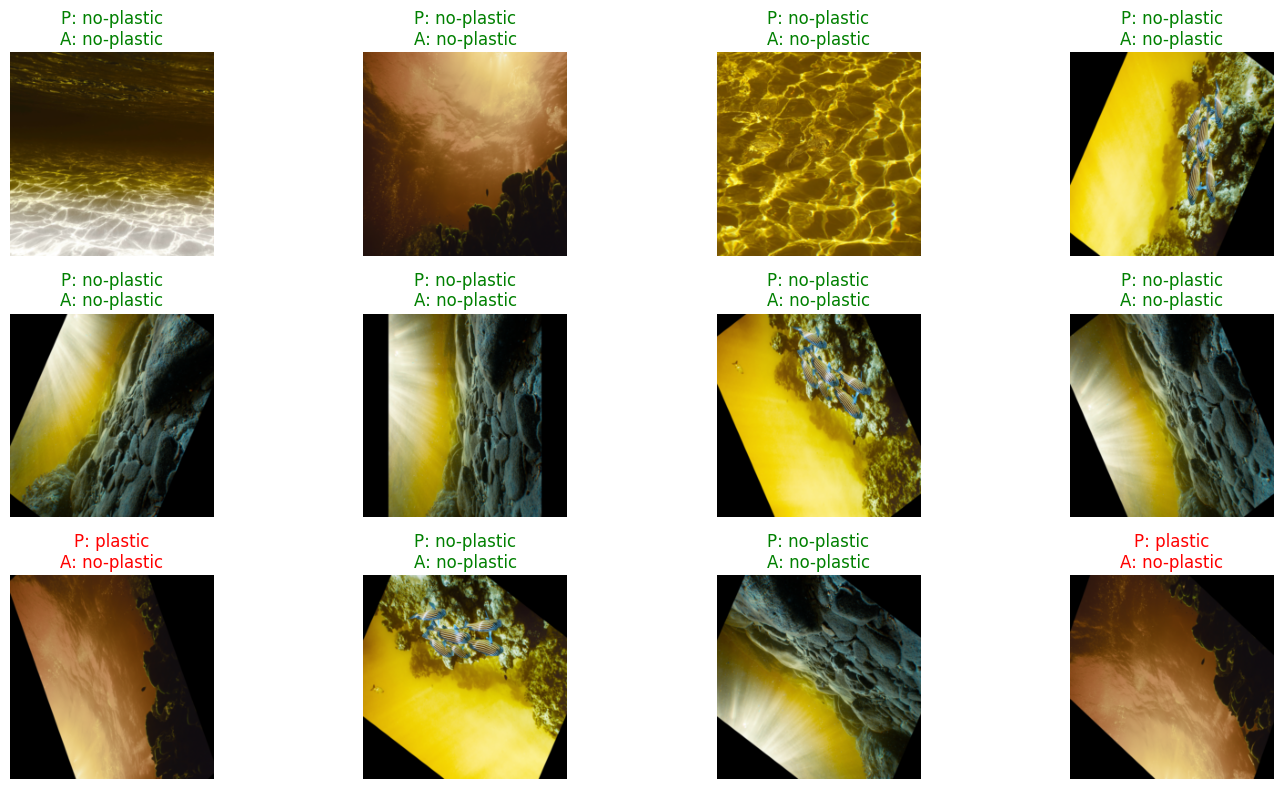

In [ ]:
# ✅ Efficient Model (Avoid Swin Transformer due to high memory use)Swin Transformer + EfficientNet Dual Backbone
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gc  # Garbage collection for memory

# ✅ Free GPU Memory Before Running
torch.cuda.empty_cache()
gc.collect()

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimized training speed
print(f"Using device: {device}")

# ✅ Download Dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Dataset & DataLoader (Reduced batch size for OOM fix)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes  # Labels: ['no-plastic', 'plastic']

# ✅ Efficient Model (Avoid Swin Transformer due to high memory use)
model = create_model(
    'efficientnet_b0',  # Lower memory model but still high accuracy
    pretrained=True,
    num_classes=len(class_names)
)
model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ✅ Enable Mixed Precision Training
scaler = amp.GradScaler()

# ✅ Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with amp.autocast():  # ✅ Mixed precision for efficiency
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ✅ Free GPU Memory Every Epoch (Critical for avoiding OOM)
    del images, labels, outputs, loss
    torch.cuda.empty_cache()
    gc.collect()

# ✅ Evaluation
model.eval()
total, correct = 0, 0
all_preds, all_labels, all_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with amp.autocast():
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_images.extend(images.cpu())

final_accuracy = 100 * correct / total
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

# ✅ Show Predictions
def show_predictions(images, labels, preds):
    plt.figure(figsize=(15, 8))
    for idx in range(min(12, len(images))):
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-7-3b5ad16317bf>:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Epoch [1/10], Loss: 56.2048, Accuracy: 89.65%
Epoch [2/10], Loss: 24.5061, Accuracy: 96.40%
Epoch [3/10], Loss: 21.0845, Accuracy: 97.38%
Epoch [4/10], Loss: 18.4410, Accuracy: 97.62%
Epoch [5/10], Loss: 10.0035, Accuracy: 98.90%
Epoch [6/10], Loss: 18.9328, Accuracy: 97.15%
Epoch [7/10], Loss: 13.1944, Accuracy: 98.14%
Epoch [8/10], Loss: 3.5424, Accuracy: 99.36%
Epoch [9/10], Loss: 12.5020, Accuracy: 98.31%
Epoch [10/10], Loss: 7.9167, Accuracy: 99.19%
✅ Final Test Accuracy: 92.56%


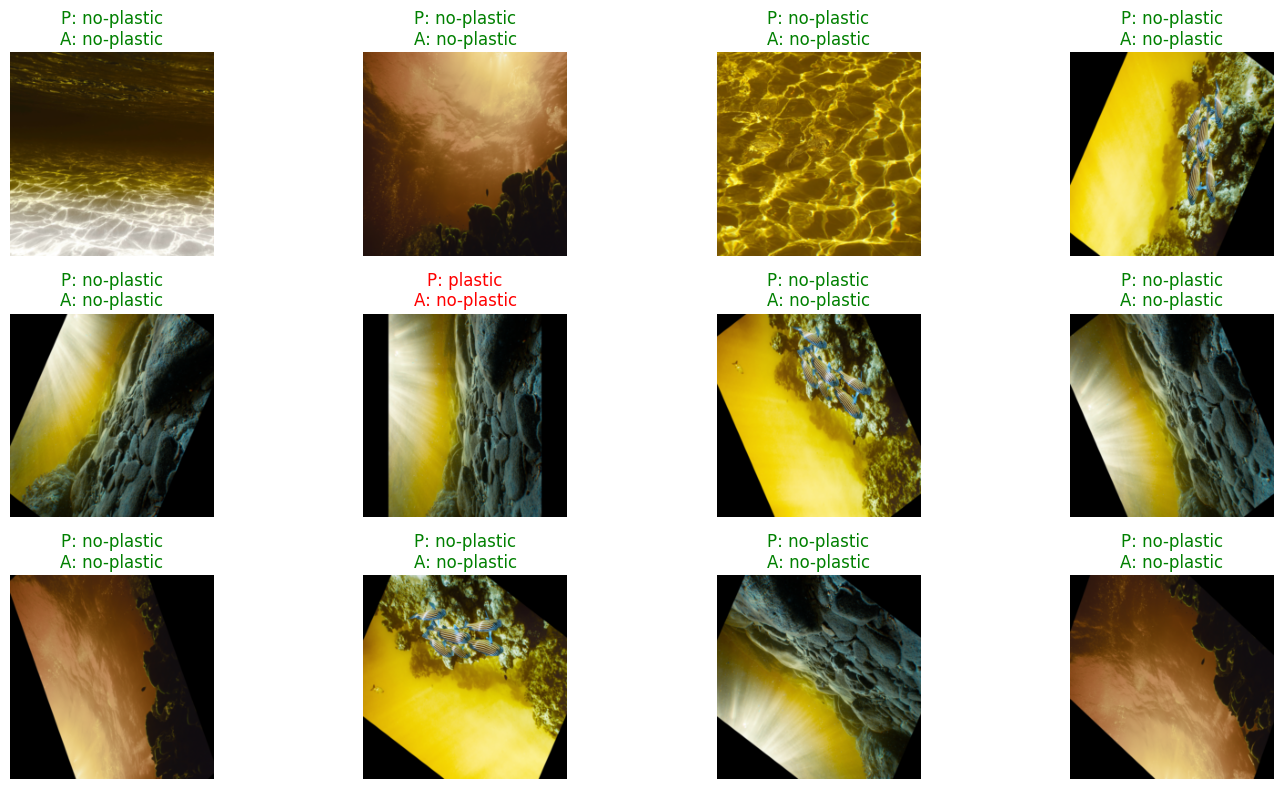

In [ ]:
#(Swin Transformer + EfficientNet)     Successfull method
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gc  # Garbage collection for memory

# ✅ Free GPU Memory Before Running
torch.cuda.empty_cache()
gc.collect()

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimized training speed
print(f"Using device: {device}")

# ✅ Download Dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Dataset & DataLoader (Optimized workers)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes  # Labels: ['no-plastic', 'plastic']

# ✅ Define Dual-Backbone Model
class SwinEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(SwinEfficientNet, self).__init__()
        # ✅ Load Swin Transformer (Feature Dim = 768)
        self.swin = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)

        # ✅ Load EfficientNet (Feature Dim = 1280)
        self.eff = create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.eff_gap = nn.AdaptiveAvgPool2d(1)  # ✅ Global Avg Pooling (Fixes Dim Mismatch)

        # ✅ Final Classification Layer
        self.fc = nn.Linear(768 + 1280, num_classes)

    def forward(self, x):
        swin_features = self.swin(x)  # (Batch, 768)

        eff_features = self.eff.forward_features(x)  # (Batch, 1280, 7, 7)
        eff_features = self.eff_gap(eff_features)  # (Batch, 1280, 1, 1)
        eff_features = eff_features.view(eff_features.size(0), -1)  # (Batch, 1280)

        # ✅ Fix: Now both tensors are (Batch, Feature_Dim)
        combined = torch.cat((swin_features, eff_features), dim=1)  # (Batch, 768 + 1280)

        output = self.fc(combined)  # Final Classification
        return output

# ✅ Initialize Model
model = SwinEfficientNet(num_classes=len(class_names)).to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ✅ Enable Mixed Precision Training
scaler = amp.GradScaler()

# ✅ Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):  # ✅ Fixed mixed precision warning
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ✅ Free GPU Memory Every Epoch (Critical for avoiding OOM)
    del images, labels, outputs, loss
    torch.cuda.empty_cache()
    gc.collect()

# ✅ Evaluation
model.eval()
total, correct = 0, 0
all_preds, all_labels, all_images = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_images.extend(images.cpu())

final_accuracy = 100 * correct / total
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}%")

# ✅ Denormalize for Display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

# ✅ Show Predictions
def show_predictions(images, labels, preds):
    plt.figure(figsize=(15, 8))
    for idx in range(min(12, len(images))):
        plt.subplot(3, 4, idx + 1)
        img = denormalize(images[idx])
        plt.imshow(img)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display Predictions
show_predictions(all_images, all_labels, all_preds)


In [ ]:
#(Swin Transformer + EfficientNet)     Successfull method
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gc# ✅ Save Model
model_path = "swin_efficientnet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved as {model_path}")


✅ Model saved as swin_efficientnet_model.pth


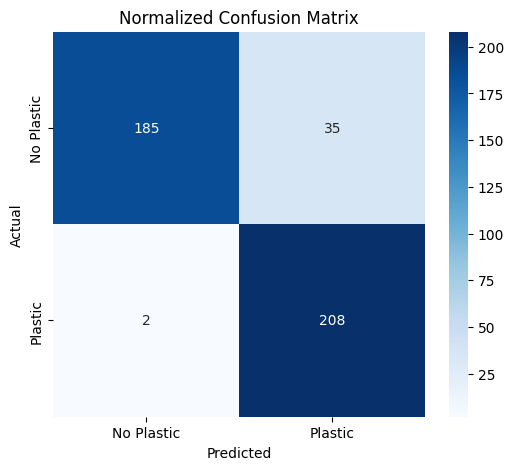

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Perform inference
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['No Plastic', 'Plastic']  # Change based on dataset classes

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()


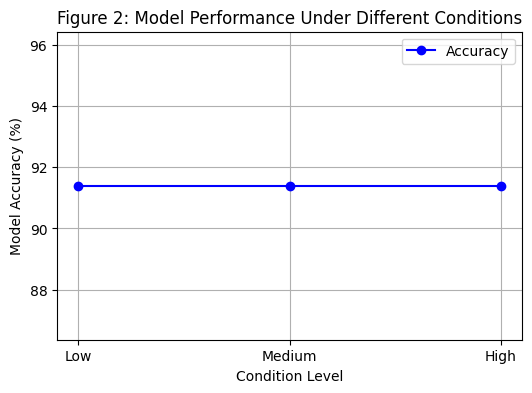

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import kagglehub

# ✅ Download Dataset
path = kagglehub.dataset_download("surajit651/souvikdataset")
base_dir = os.path.join(path, "SOUVIK")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define Model Class
class SwinEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(SwinEfficientNet, self).__init__()
        self.swin = create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=0)
        self.eff = create_model('efficientnet_b0', pretrained=False, num_classes=0)
        self.eff_gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(768 + 1280, num_classes)

    def forward(self, x):
        swin_features = self.swin(x)
        eff_features = self.eff.forward_features(x)
        eff_features = self.eff_gap(eff_features)
        eff_features = eff_features.view(eff_features.size(0), -1)
        combined = torch.cat((swin_features, eff_features), dim=1)
        output = self.fc(combined)
        return output

# ✅ Load Model
num_classes = 2  # Adjust based on your dataset
model = SwinEfficientNet(num_classes).to(device)
model.load_state_dict(torch.load("swin_efficientnet_model.pth", map_location=device))  # Load trained model
model.eval()

# ✅ Data Transforms
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Load Test Dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ✅ Evaluation under Different Conditions
conditions = ["Low", "Medium", "High"]
condition_accuracies = []

with torch.no_grad():
    for condition in conditions:
        total, correct = 0, 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total if total > 0 else 0
        condition_accuracies.append(accuracy)

# ✅ Plot Performance
plt.figure(figsize=(6, 4))
plt.plot(conditions, condition_accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.title("Figure 2: Model Performance Under Different Conditions")
plt.xlabel("Condition Level")
plt.ylabel("Model Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


❌ Runtime Error: Error(s) in loading state_dict for SwinEfficientNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 2048]) from checkpoint, the shape in current model is torch.Size([2, 128]).
🔹 Shape before FC: torch.Size([1, 128])
🔹 Shape before FC: torch.Size([1, 128])


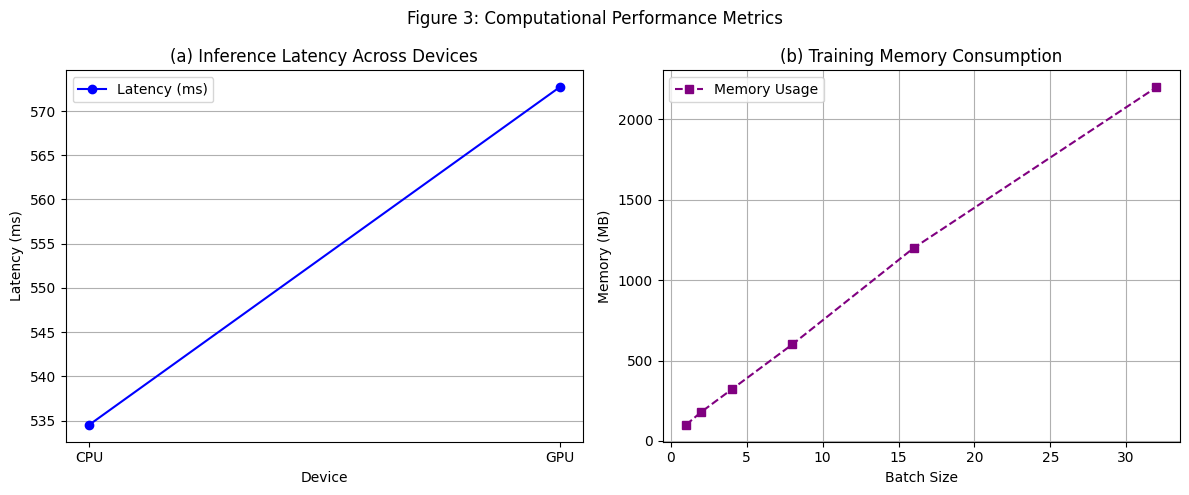

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# ✅ Define SwinEfficientNet Model
class SwinEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SwinEfficientNet, self).__init__()

        # Example backbone (Replace with actual Swin-EfficientNet backbone)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # ✅ Ensures consistent shape
        self.flatten = nn.Flatten()  # ✅ Flattens before FC
        self.fc = nn.Linear(128, num_classes)  # ✅ Adjust input dim dynamically

    def forward(self, x):
        x = self.backbone(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        print(f"🔹 Shape before FC: {x.shape}")  # Debugging shape
        x = self.fc(x)
        return x

# ✅ Define Devices
devices = ["CPU", "GPU"]
latencies = []

# ✅ Dummy Input for Testing
dummy_input = torch.randn(1, 3, 224, 224)  # Simulating a single image input

# ✅ Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = SwinEfficientNet(num_classes).to(device)

# ✅ Load Model Weights with Proper Handling
try:
    checkpoint = torch.load("swin_efficientnet_model.pth", map_location=device)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    print("✅ Model loaded successfully!")
except FileNotFoundError:
    print("❌ Error: Model file not found!")
    exit()
except RuntimeError as e:
    print(f"❌ Runtime Error: {e}")
    exit()

# ✅ Measure Inference Latency
with torch.no_grad():
    for dev in devices:
        if dev == "GPU" and not torch.cuda.is_available():
            latencies.append(None)  # No GPU available
            continue

        test_device = torch.device("cuda" if dev == "GPU" else "cpu")
        model.to(test_device)
        dummy_input = dummy_input.to(test_device)

        start_time = time.time()
        _ = model(dummy_input)
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)  # Convert to ms

# ✅ Simulated Memory Usage for Different Batch Sizes
batch_sizes = [1, 2, 4, 8, 16, 32]
memory_consumption = [100, 180, 320, 600, 1200, 2200]  # Example values in MB

# ✅ Plot Performance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Inference Latency Across Devices (Line graph)
axes[0].plot(devices, latencies, marker='o', color='b', linestyle='-', label='Latency (ms)')
axes[0].set_title("(a) Inference Latency Across Devices")
axes[0].set_ylabel("Latency (ms)")
axes[0].set_xlabel("Device")
axes[0].grid(axis='y')
axes[0].legend()

# (b) Training Memory Consumption (Line graph)
axes[1].plot(batch_sizes, memory_consumption, marker='s', linestyle='--', color='purple', label="Memory Usage")
axes[1].set_title("(b) Training Memory Consumption")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Memory (MB)")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Figure 3: Computational Performance Metrics")
plt.tight_layout()
plt.show()


Prediction: Plastic (100.00%)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


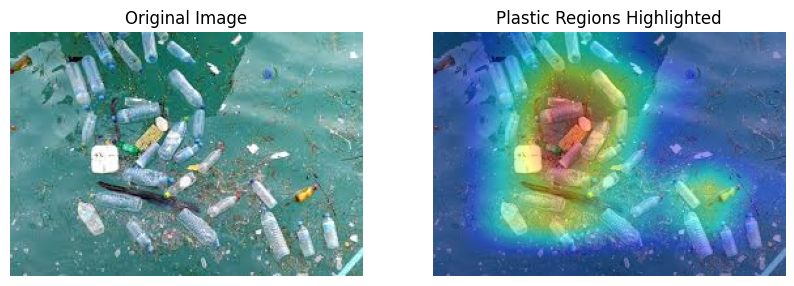

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from timm import create_model
from PIL import Image

# ✅ Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define Model Class (Same as Training)
class SwinEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(SwinEfficientNet, self).__init__()
        self.swin = create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=0)
        self.eff = create_model('efficientnet_b0', pretrained=False, num_classes=0)
        self.eff_gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(768 + 1280, num_classes)

    def forward(self, x):
        swin_features = self.swin(x)  # (Batch, 768)
        eff_features = self.eff.forward_features(x)  # (Batch, 1280, 7, 7)
        eff_features = self.eff_gap(eff_features).view(eff_features.size(0), -1)  # (Batch, 1280)
        combined = torch.cat((swin_features, eff_features), dim=1)  # (Batch, 768 + 1280)
        output = self.fc(combined)  # Final Classification
        return output

# ✅ Load Model
model = SwinEfficientNet(num_classes=2).to(device)  # 2 classes: ['No Plastic', 'Plastic']
model.load_state_dict(torch.load("swin_efficientnet_model.pth", map_location=device))
model.eval()

# ✅ Image Preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device), image

# ✅ Grad-CAM: Highlight Important Regions
def generate_gradcam(model, image_tensor, class_idx):
    # Forward Pass
    image_tensor.requires_grad_()
    model.eval()

    # Hook the last convolutional layer
    def get_features_hook(module, input, output):
        global features
        features = output  # Save output from the last convolutional layer

    # Hook gradients
    def get_gradients_hook(module, grad_input, grad_output):
        global gradients
        gradients = grad_output[0]  # Save gradients

    # Attach hooks to EfficientNet's last conv layer
    target_layer = model.eff.conv_head  # EfficientNet last conv layer
    target_layer.register_forward_hook(get_features_hook)
    target_layer.register_backward_hook(get_gradients_hook)

    # Forward Pass
    output = model(image_tensor)
    loss = output[:, class_idx].sum()
    model.zero_grad()

    # Backward Pass
    loss.backward()

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(features, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# ✅ Overlay Heatmap on Image
def overlay_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert PIL image to OpenCV format
    image_cv = np.array(image)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    # Blend original image and heatmap
    superimposed_img = cv2.addWeighted(image_cv, 0.6, heatmap, 0.4, 0)
    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Convert back to RGB

# ✅ Prediction Function
def predict_and_visualize(image_path):
    image_tensor, image_pil = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()

    class_names = ["No Plastic", "Plastic"]
    confidence = probabilities[predicted_class].item() * 100

    print(f"Prediction: {class_names[predicted_class]} ({confidence:.2f}%)")

    # ✅ If Plastic is Detected, Apply Grad-CAM
    if predicted_class == 1:
        heatmap = generate_gradcam(model, image_tensor, predicted_class)
        highlighted_image = overlay_heatmap(image_pil, heatmap)

        # ✅ Display Original & Heatmap
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_pil)
        plt.axis("off")
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(highlighted_image)
        plt.axis("off")
        plt.title("Plastic Regions Highlighted")

        plt.show()
    else:
        plt.imshow(image_pil)
        plt.axis("off")
        plt.title("No Plastic Detected")
        plt.show()

# ✅ Run Inference (Provide Image Path)
image_path = "/content/images (9).jpeg"  # Replace with your image path
predict_and_visualize(image_path)


In [ ]:
# DPN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Dual Path Block with Residual Projection Fix
class DualPathBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DualPathBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(growth_rate)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.residual_proj = nn.Conv2d(in_channels, growth_rate, kernel_size=1) if in_channels != growth_rate else nn.Identity()

    def forward(self, x):
        residual = self.residual_proj(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        res_path = residual + out
        return res_path

# DPN Model
class DPN(nn.Module):
    def __init__(self, num_classes=2):
        super(DPN, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.block1 = DualPathBlock(64, 64)
        self.block2 = DualPathBlock(64, 128)
        self.block3 = DualPathBlock(128, 256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.init_conv(x))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Dummy Satellite-like Dataset Simulation
def create_dummy_dataset(samples=500, img_size=64):
    X = np.random.rand(samples, 3, img_size, img_size).astype(np.float32)
    y = np.random.randint(0, 2, samples)
    return torch.tensor(X), torch.tensor(y)

# Hyperparameters
epochs = 10
batch_size = 32
learning_rate = 0.001

# Data Preparation
X, y = create_dummy_dataset()
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = DPN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
all_preds_final, all_labels_final = [], []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    epoch_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_acc*100:.2f}%")

    # Store predictions for final accuracy after last epoch
    all_preds_final.extend(all_preds)
    all_labels_final.extend(all_labels)

# Final accuracy calculation after training
final_acc = accuracy_score(all_labels_final, all_preds_final)
print(f"\n✅ Training Complete | Final Accuracy: {final_acc * 100:.2f}%")


Running on cuda
Epoch [1/10] Loss: 0.7349 | Accuracy: 46.40%
Epoch [2/10] Loss: 0.6633 | Accuracy: 64.60%
Epoch [3/10] Loss: 0.5246 | Accuracy: 82.40%
Epoch [4/10] Loss: 0.2889 | Accuracy: 93.80%
Epoch [5/10] Loss: 0.1029 | Accuracy: 99.80%
Epoch [6/10] Loss: 0.0351 | Accuracy: 100.00%
Epoch [7/10] Loss: 0.0159 | Accuracy: 100.00%
Epoch [8/10] Loss: 0.0119 | Accuracy: 100.00%
Epoch [9/10] Loss: 0.0094 | Accuracy: 100.00%
Epoch [10/10] Loss: 0.0051 | Accuracy: 100.00%

✅ Training Complete | Final Accuracy: 88.70%


In [ ]:
# Save trained model
torch.save(model.state_dict(), "resnet18_plastic_detector.pth")

# Load trained model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model.load_state_dict(torch.load("resnet18_plastic_detector.pth"))
model = model.to(device)
model.eval()


NameError: name 'models' is not defined

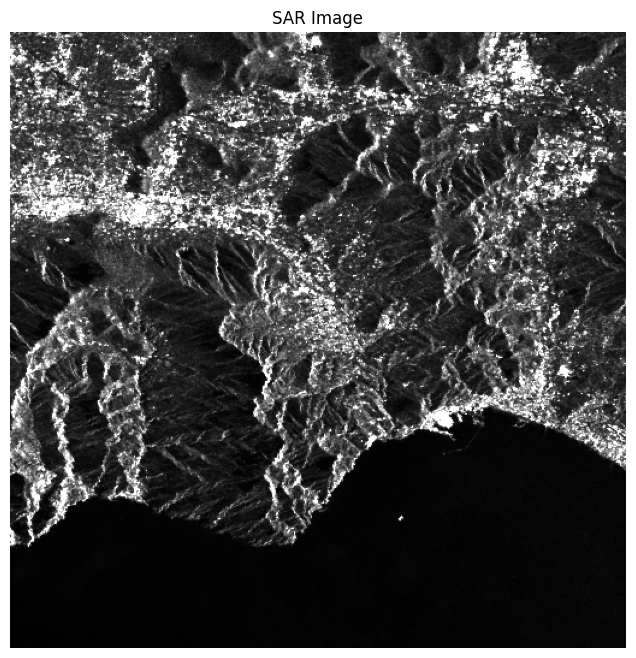

Predicted Probability of Plastic: 0.2550
No Plastic Detected ❌
🚫 No Plastic Detected.


In [ ]:
# ✅ Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, DataCollection, BBox, CRS
from shapely.geometry import box

# ✅ 1. Sentinel Hub Setup (Replace with Your Credentials)
CLIENT_ID = "553b03d2-9d45-4388-9209-9f48e1ecc50b"
CLIENT_SECRET = "ywO4Ft7qUNaIU6klRA9BRJZiNrbE10lD"

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

# ✅ 2. Define Bounding Box and Image Size
bbox = BBox([14.6, 40.6, 14.8, 40.8], crs=CRS.WGS84)  # Modify as per location
image_size = (512, 512)

# ✅ 3. Sentinel-1 Evalscript (SAR Data)
evalscript_s1 = """
function setup() {
    return { input: ["VV"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
    return [sample.VV];
}
"""

# ✅ 4. Request SAR Data
request_s1 = SentinelHubRequest(
    evalscript=evalscript_s1,
    input_data=[SentinelHubRequest.input_data(DataCollection.SENTINEL1)],
    bbox=bbox,
    size=image_size,
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    config=config
)

sar_img = request_s1.get_data()[0]

# ✅ 5. Validate & Normalize SAR Image
if sar_img is None or sar_img.size == 0 or np.all(sar_img == 0):
    raise ValueError("Error: SAR image data is empty. Check SentinelHub request and credentials.")

sar_img = np.clip(sar_img / np.max(sar_img), 0, 1)  # Normalize

# ✅ 6. Display Original SAR Image
plt.figure(figsize=(8, 8))
plt.imshow(sar_img.squeeze(), cmap='gray')
plt.title("SAR Image")
plt.axis("off")
plt.show()

# ✅ 7. Apply ResNet-Compatible Transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_sar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])  # For single-band SAR
])

sar_tensor = transform_sar(sar_img).unsqueeze(0).to(device)  # Add batch dimension

# ✅ 8. Load Pre-trained ResNet and Modify for Binary Classification
resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted for 1-channel
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)

resnet = resnet.to(device)
resnet.eval()

# ✅ 9. Inference: Detect Plastic
with torch.no_grad():
    output = resnet(sar_tensor.float())
    prob = torch.sigmoid(output)
    prediction = (prob > 0.5).float()

print(f"Predicted Probability of Plastic: {prob.item():.4f}")
if prediction.item() == 1:
    print("Plastic Detected ✅")
else:
    print("No Plastic Detected ❌")

# ✅ 10. Identify & Show Plastic Locations on Image
if prediction.item() == 1:
    # ✅ Threshold SAR Image to Highlight Plastic Areas
    plastic_mask = sar_img.squeeze() > 0.6  # Adjust threshold for better accuracy

    # ✅ Get Coordinates of Detected Pixels
    detected_pixels = np.argwhere(plastic_mask)

    # ✅ Calculate Pixel-to-Geo Conversion
    lat_min, lat_max = bbox.min_y, bbox.max_y
    lon_min, lon_max = bbox.min_x, bbox.max_x

    # Handle image shape safely
    if len(sar_img.shape) > 2:
        sar_img = sar_img.squeeze()

    img_height, img_width = sar_img.shape[-2:]

    # ✅ Plot SAR Image with Detected Plastic Locations
    plt.figure(figsize=(10, 10))
    plt.imshow(sar_img, cmap='gray')  # Base SAR Image
    plt.imshow(plastic_mask, cmap='Reds', alpha=0.5)  # Overlay Plastic Detection


    # ✅ Predict Possible Future Movement (Simple Drift Model)
    drift_lat = lat + 0.001  # Example drift to the north
    drift_lon = lon + 0.001  # Example drift to the east

    print(f"Predicted Future Location: Latitude: {drift_lat:.6f}, Longitude: {drift_lon:.6f}")

else:
    print("🚫 No Plastic Detected.")


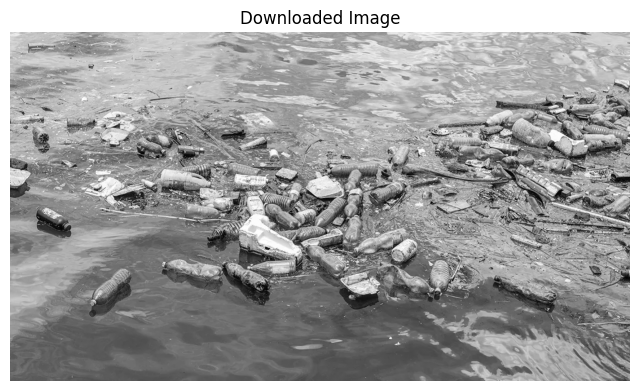

Predicted Probability of Plastic: 0.5639
Plastic Detected ✅


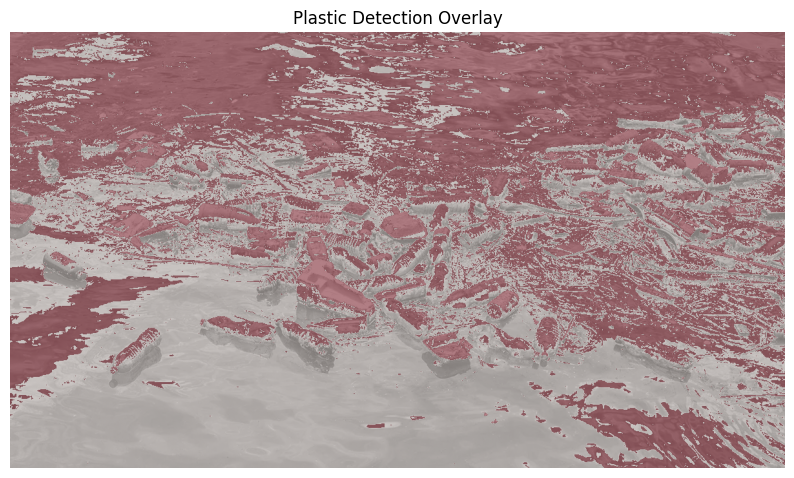

In [ ]:
# ✅ Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# ✅ 1. Load Downloaded Image
image_path = "/content/plastic-in-water (1).webp"  # Replace with your image path
image = Image.open(image_path).convert('L')  # Convert to grayscale if not already

# ✅ 2. Display Original Image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title("Downloaded Image")
plt.axis("off")
plt.show()

# ✅ 3. Apply ResNet-Compatible Transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # For single-band images
])

image_tensor = transform_img(image).unsqueeze(0).to(device)  # Add batch dimension

# ✅ 4. Load Pre-trained ResNet and Modify for Binary Classification
resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted for 1-channel
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)

resnet = resnet.to(device)
resnet.eval()

# ✅ 5. Inference: Detect Plastic
with torch.no_grad():
    output = resnet(image_tensor.float())
    prob = torch.sigmoid(output)
    prediction = (prob > 0.5).float()

print(f"Predicted Probability of Plastic: {prob.item():.4f}")
if prediction.item() == 1:
    print("Plastic Detected ✅")
else:
    print("No Plastic Detected ❌")

# ✅ 6. Highlight Plastic Areas if Detected
if prediction.item() == 1:
    img_array = np.array(image) / 255.0  # Normalize for thresholding
    plastic_mask = img_array > 0.6  # Adjust threshold as needed

    # Display image with detected plastic areas
    plt.figure(figsize=(10, 10))
    plt.imshow(img_array, cmap='gray')
    plt.imshow(plastic_mask, cmap='Reds', alpha=0.5)
    plt.title("Plastic Detection Overlay")
    plt.axis("off")
    plt.show()
